In [ ]:
# Example: My preferred approach
import os
# Settings -> Developer Settings -> Personal Access Tokens -> Token (classic)
os.environ['GITHUB_TOKEN'] = ""

GITHUB_USERNAME = "Codfishz"
REPO_NAME       = "ASR"
TOKEN = os.environ.get("GITHUB_TOKEN")
repo_url        = f"https://{TOKEN}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"
!git clone {repo_url}

Cloning into 'ASR'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 6), reused 21 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 5.94 MiB | 6.61 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [4]:
!cd {REPO_NAME} && git pull

Already up to date.


In [5]:
import os
os.chdir('ASR/Script')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2
Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/crop-pest-and-disease-detection
License(s): CC0-1.0
['Maize leaf beetle', 'Maize streak virus', 'Cassava green mite', 'Maize healthy', 'Cashew healthy', 'Maize leaf spot', 'Cassava bacterial blight', 'Tomato leaf blight', 'Maize fall armyworm', 'Cassava healthy', 'Maize grasshoper', 'Cashew gumosis', 'Tomato verticulium wilt', 'Tomato healthy', 'Tomato leaf curl', 'Tomato septoria leaf spot', 'Cashew leaf miner', 'Maize leaf blight', 'Cashew red rust', 'Cassava mosaic', 'Cassava brown spot', 'Cashew anthracnose']


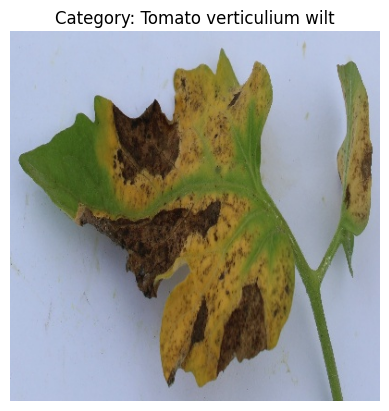

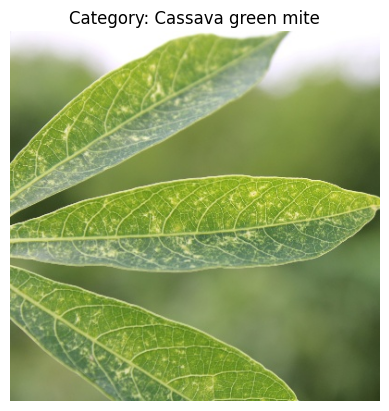

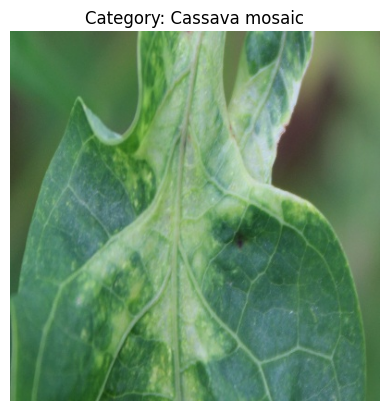

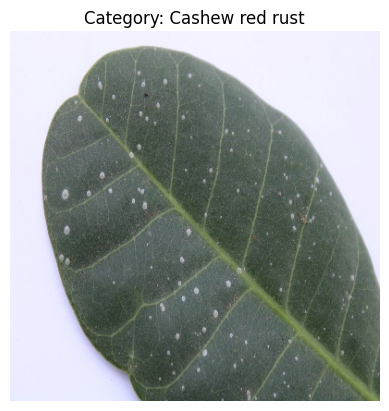

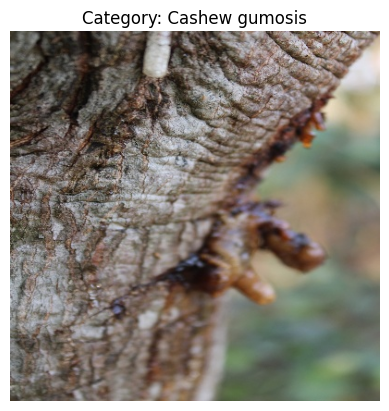

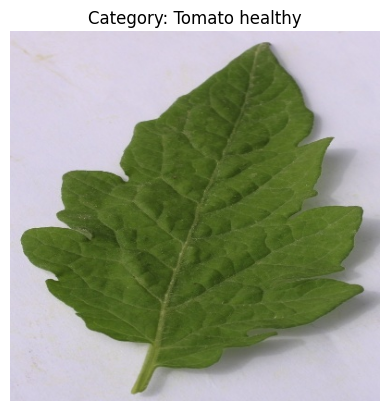

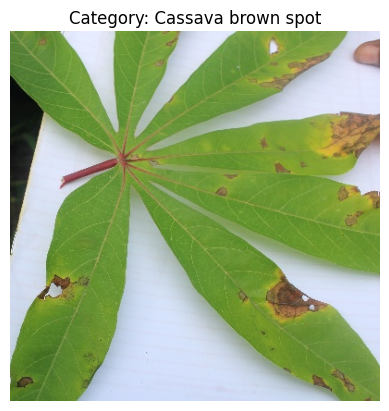

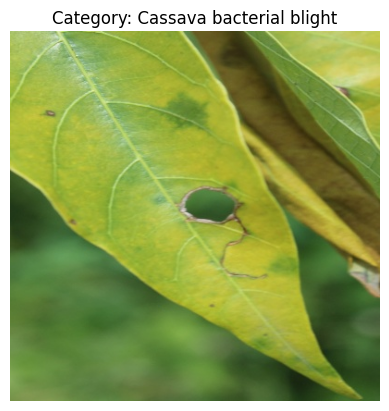

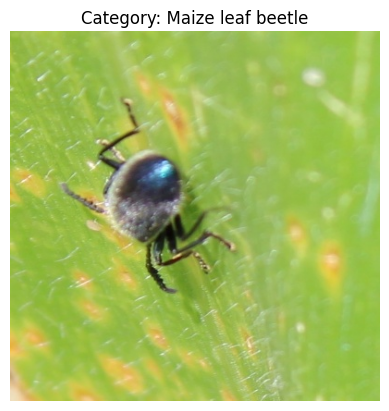

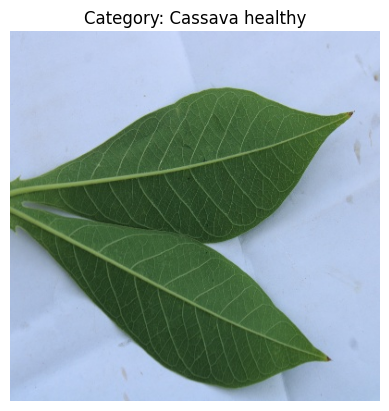

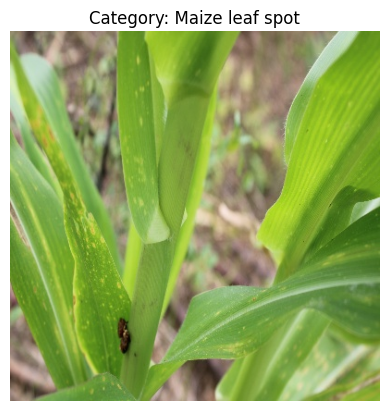

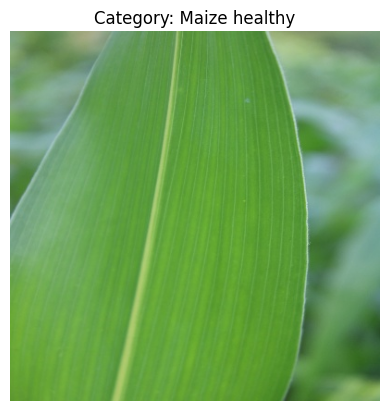

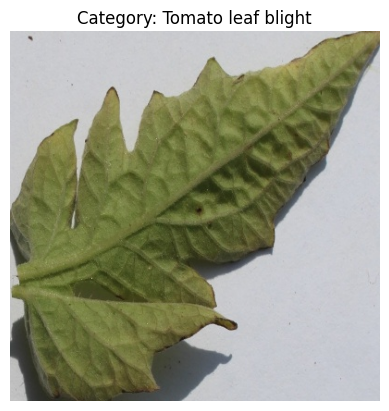

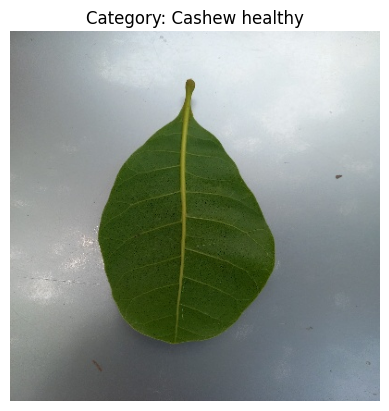

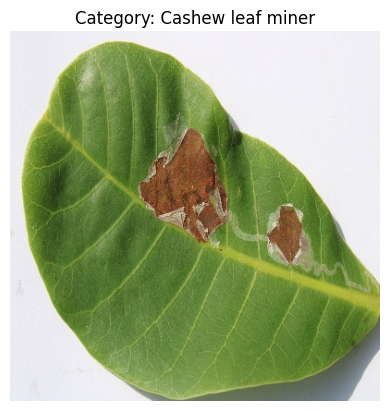

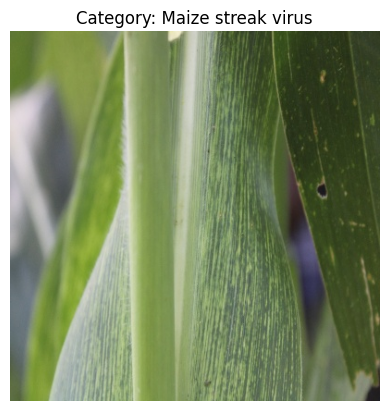

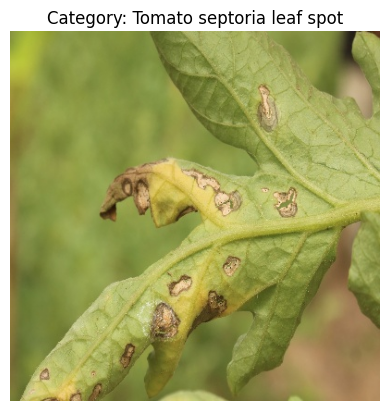

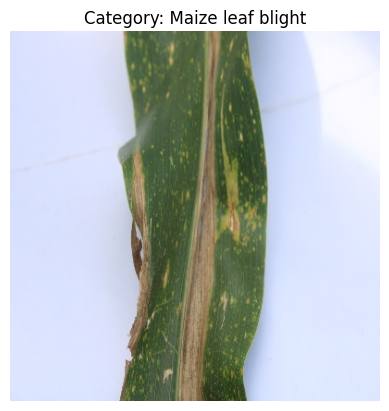

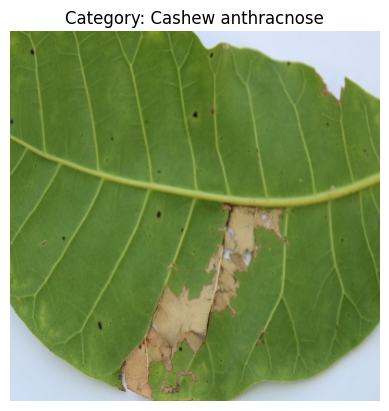

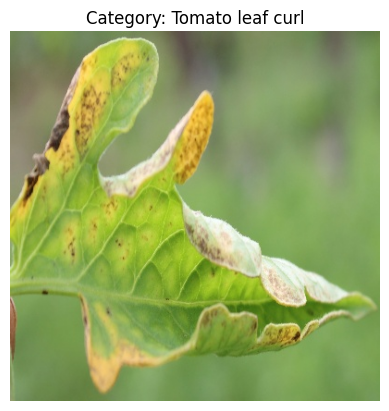

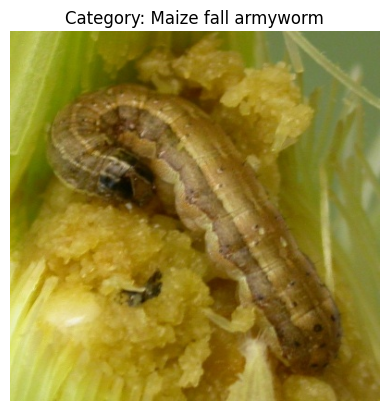

Processing 'Maize fall armyworm': 100%|██████████| 285/285 [00:00<00:00, 821.54it/s]


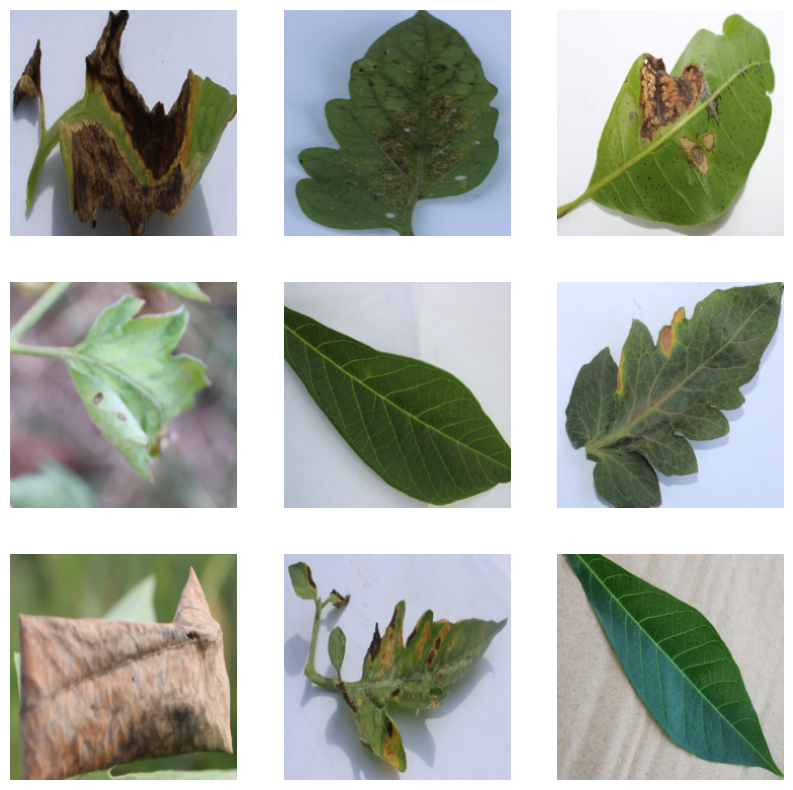

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


24453


100%|██████████| 44.7M/44.7M [00:00<00:00, 231MB/s]
Extracting features: 100%|██████████| 96/96 [01:39<00:00,  1.04s/it]

Features shape: torch.Size([24453, 512])
Labels shape: torch.Size([24453])


In [7]:
%run "Dataloader_FeatureExtraction.ipynb"

In [8]:
!pip install ultralytics
!pip install torchinfo

import ultralytics
ultralytics.checks()

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 42.5/235.7 GB disk)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from ultralytics import YOLO
print("GPU available:", torch.cuda.is_available())

GPU available: True


In [27]:
from ultralytics import YOLO
from torchinfo import summary

model = YOLO("yolo11n-cls.pt")
summary(model.model.cuda(), input_size=(1, 3, 640, 640))
net = model.model

100%|██████████| 5.52M/5.52M [00:00<00:00, 365MB/s]


In [13]:
# results_train = model.train(data='coco128.yaml', epochs=10, imgsz=640)

In [14]:
# results_val = model.val()

In [28]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [32]:
  !ls

Dataloader_FeatureExtraction.ipynb  runs	    yolov8n.pt
datasets			    yolo11n-cls.pt
mc_dropout.ipynb		    YOLO.ipynb


In [29]:
def active_learning_selector(model, dataset, candidate_indices, num_select):


    return np.random.choice(candidate_indices, num_select, replace=False).tolist()

In [30]:
print(len(dataset))

24453


In [ ]:
# https://docs.ultralytics.com/zh/datasets/classify/#folder-structure-example

In [31]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0

    for batch_idx, (images, targets) in enumerate(dataloader):
        images = images.cuda() if torch.cuda.is_available() else images
        targets = [{k: v.cuda() if torch.cuda.is_available() else v for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        pred = model(images)  # Forward pass
        loss, loss_items = model.compute_loss(pred, targets)  # YOLO 自带损失函数
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx+1}: Loss = {loss.item():.4f}")

    print(f"Epoch {epoch+1} finished, avg loss: {running_loss / (batch_idx+1):.4f}")

    # Active Learning 部分：选择一部分数据重新标注或训练
    candidate_indices = list(range(len(dataset)))
    new_indices = active_learning_selector(model, dataset, candidate_indices, num_select=int(len(candidate_indices) * 0.5))

    active_sampler.update_indices(new_indices)

    dataloader = DataLoader(dataset, batch_size=256, sampler=active_sampler, num_workers=0, pin_memory=True)


Epoch 1/10
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=../datasets/imagenet, epochs=100, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

RuntimeError: Dataset '../datasets/imagenet' error ❌ [Errno 2] No such file or directory: '/content/ASR/Script/datasets/imagenet/train'

In [23]:

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    net.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.cuda() if torch.cuda.is_available() else images
        labels = labels.cuda() if torch.cuda.is_available() else labels

        optimizer.zero_grad()
        # outputs = net(images)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()

        pred = model(images)
        loss, loss_items = compute_loss(pred, targets)  # 自带的 loss 函数
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx+1}: Loss = {loss.item():.4f}")

    print(f"Epoch {epoch+1} finished, avg loss: {running_loss / (batch_idx+1):.4f}")

    candidate_indices = list(range(len(dataset)))
    new_indices = active_learning_selector(net, dataset, candidate_indices, num_select=int(len(candidate_indices)*0.5))

    active_sampler.update_indices(new_indices)

    dataloader = DataLoader(dataset, batch_size=256, sampler=active_sampler, num_workers=0, pin_memory=True)

Epoch 1/10


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
# results_pred = model.predict(source="/content/datasets/coco128/images/val2017", conf=0.25)

# for result in results_pred:
#     result.show()


# print("Result Train：", results_train)
# print("Result Validation：", results_val)

FileNotFoundError: /content/datasets/coco128/images/val2017 does not exist